In [1]:
# Import packages
import cmath
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score as r2
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
tf.executing_eagerly()

True

In [2]:
# Define initial state
state_i = tf.constant([[1.0], [0.0]], dtype='complex128')

# Define U3 gate
def u3_matrix(theta, phi, lamda):
    if theta == 0.0 and phi == 0.0 and lamda == 0.0:
        return np.array([[0.0, 0.0], [0.0, 0.0]])
    return np.array([[np.cos(theta/2),                  -cmath.exp(1j*lamda)*np.sin(theta/2)],
                    [cmath.exp(1j*phi)*np.sin(theta/2), cmath.exp(1j*(phi+lamda))*np.cos(theta/2)]])

# Transform theta, phi, lambda parameters
def matrix_transform(X):
    new_X = []
    for parameter_list in X:
        temp = []
        for k in range(len(parameter_list)//3):
            temp.append(u3_matrix(*parameter_list[3*k:3*k+3]))
        new_X.append(temp)
    return np.array(new_X)

# Create multilinear features
def multi_features(X):
    new_X = []
    num_matrices = len(X[0])
    for k in range(len(X)):
        new_X.append([X[k][0]])
        for mult_idx in range(1, num_matrices):
            new_X[k].append(np.dot(X[k][mult_idx], new_X[k][-1]))
    return np.array(new_X)

# Reverse multilinear features
def reverse(X):
    new_X = []
    num_matrices = len(X[0])
    for k in range(len(X)):
        p1 = np.array([])
        p2 = np.array([])
        for mat in range(num_matrices):
            if X[k][mat][0][0] == 0.0 and X[k][mat][0][1] == 0.0:
                p1 = X[k][:mat]
                p2 = X[k][mat:]
                break
        p1 = p1[::-1]
        if len(p1) == 0 and len(p2) == 0:
            temp = np.concatenate([X[k][:num_matrices-1][::-1], [X[k][-1]]])
        else:
            temp = np.concatenate([p1, p2])
        new_X.append(temp)
    return np.array(new_X)

# Load data from data set
def load_data(num_gates):
    with open('..//..//Data Collection//Yorktown//dataset_york.p', 'rb') as f:
        data_set = pk.load(f)
    X, Y = multi_features(matrix_transform(data_set['X'])), np.array(data_set['Y'])
    X_order = np.array(reverse(X))
    features = num_gates
    data_size = len(X)
    X, Y = X_order.reshape(data_size,features,2,2), Y.reshape(data_size,1)
    data = (train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=42))
    return data, data_size

# Predict model output
def predict(x_input):
    weights = tf.complex(real, im)
    product = tf.matmul(weights, x_input)
    operator_f = tf.reduce_sum(product, axis=1)
    born_zero = tf.matmul(tf.transpose(tf.matmul(operator_f, state_i), perm=[0,2,1]), state_i)
    y_predict = tf.square(tf.abs(tf.reduce_sum(born_zero, axis=1)))
    return y_predict

# Define loss function
def loss():
    y_predict = predict(x_train)
    cost = tf.reduce_sum(tf.square(y_train-y_predict))/(len(x_train))
    return cost

# Train model
def train(num_epochs):
    epochs = list(range(num_epochs))
    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.2)
    rmse_list = []
    test_rmse_list = []
    for i in epochs:
        opt.minimize(loss, var_list=[real])
        rmse_list.append(np.sqrt(loss().numpy()))
        y_predict = predict(x_test)
        test_rmse_list.append(np.sqrt(mean_squared_error(y_test, y_predict)))
    return rmse_list, test_rmse_list

In [3]:
# Load data
num_gates = 100
data, data_size = load_data(num_gates)
x_train, x_test, y_train, y_test = data

In [4]:
# RMSE lists
rmse_i = []
rmse_f = []

# Initialize theoretical weights
features = num_gates
real = tf.Variable([[[1.0,0.0],[0.0,1.0]]] + [[[0.0,0.0],[0.0,0.0]]]*(features-1), dtype='float64')
im = tf.Variable([[[0.0,0.0],[0.0,0.0]]]*features, dtype='float64')
y_predict = predict(x_test)
rmse_i.append(np.sqrt(mean_squared_error(y_test, y_predict)))

# Train model
num_epochs = 25
rmse_list, test_rmse_list = train(num_epochs)
rmse_f.append(test_rmse_list[-1])

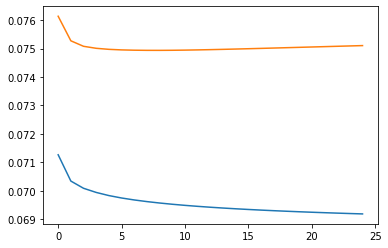

In [5]:
# Plot RMSE
plt.plot(rmse_list)
plt.plot(test_rmse_list)

In [6]:
def num_of_gates(X):
    count = 0
    while count < 100 and X[count][0][0] != 0.0 and X[count][0][1] != 0.0:
        count += 1
    return count

# Concatenate data
x_all = np.concatenate([x_train, x_test])
y_all = np.concatenate([y_train, y_test])
y_predict = predict(x_all).numpy()

# Calculate fidelity difference: expected - predicted
fid_dict = {}
for k in range(100):
    fid_dict[k+1] = []   
for k in range(len(y_predict)):
    g = num_of_gates(x_all[k])
    fid_dict[g].append(y_all[k][0] - y_predict[k][0])

In [7]:
# Evaluate model
rmse_multi = []
for k in range(1,99):
    temp = np.array(fid_dict[k+1])
    x = np.sqrt(np.sum(temp**2)/len(temp))
    rmse_multi.append(x)
print(sum(rmse_multi)/100)

0.05902963068551542


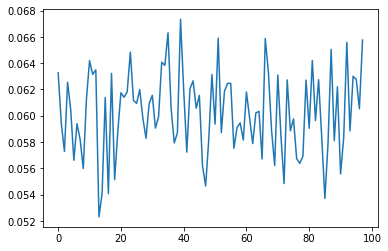

In [8]:
# Plot data
plt.plot(rmse_multi)

In [9]:
# Save data
pk.dump(rmse_multi, open('multi_york_rmse.p', 'wb'))